# acceptTime_analyze

## Purpose
This notebook documents the process of analyzing data previously extracted from PLOS article XML files.


We'll begin by importing the data we previously extracted from the PLOS article XMLs from allofplos and confirming the structure of the data.

In [20]:
import pandas as pd
df = pd.read_csv("data/2023-11-29_plostime_data.txt", sep = "\t")

print(df.shape)
df.head()

(326737, 8)


,received_date,accepted_date,epub_date,journal,article_doi,accept_time,receive_to_pub_time,accept_to_pub_time
0,2003-6-1,2003-7-10,2003-10-13,pbio,10.1371/journal.pbio.0000001,39.0,134.0,95.0
1,2003-5-19,2003-7-16,2003-11-17,pbio,10.1371/journal.pbio.0000002,58.0,182.0,124.0
2,2003-6-12,2003-7-25,2003-8-18,pbio,10.1371/journal.pbio.0000005,43.0,67.0,24.0
3,2003-6-3,2003-7-29,2003-8-18,pbio,10.1371/journal.pbio.0000006,56.0,76.0,20.0
4,2003-6-20,2003-8-1,2003-10-13,pbio,10.1371/journal.pbio.0000010,42.0,115.0,73.0


We probably aren't interested in all 326,737 articles, so let's use another function to filter the list down to the most recent published articles - in this case, articles published in the last 180 days.

In [21]:
import numpy as np
from datetime import date

def subset_data(df, journal = None, cutoff = 180):
    """
    Creates a dataframe subset based on journal and/or publication date cutoff.

    Param df: pandas dataframe
    Param journal: PLOS journal abbreviation string (e.g. pbio)
    Param cutoff: Publication date cutoff, in days from current date
    Returns: Dataframe subset based on journal and/or publication date cutoff
    """
    
    df_keep = []
    today = date.today()
    journal_list = np.unique(df.journal)
    if journal != None and journal not in journal_list:
        ValueError(f"{journal} not in list of available journals")

    if journal == None:
        for row in range(df.shape[0]):
            row_date = df.loc[row, "epub_date"].split("-")
            row_date_format = date(int(row_date[0]), int(row_date[1]), int(row_date[2]))
            row_diff = today - row_date_format
            if row_diff.days < cutoff:
                df_keep.append(row)

    else:
        for row in range(df.shape[0]):
            row_journal = df.loc[row, "journal"]
            row_date = df.loc[row, "epub_date"].split("-")
            row_date_format = date(int(row_date[0]), int(row_date[1]), int(row_date[2]))
            row_diff = today - row_date_format
            if row_diff.days < cutoff and row_journal == journal:
                df_keep.append(row)
    return(df.iloc[df_keep])

We'll create a dataframe subset using the default of 180 days, or roughly 6 months. Remember that this cutoff is based on the publication date (epub_date), so all epub_dates in the resulting dataframe subset should be within 180 days of the day of analysis.

In [22]:
df_6mo = subset_data(df)

print(df_6mo.shape)
df_6mo.head()

(8626, 8)


,received_date,accepted_date,epub_date,journal,article_doi,accept_time,receive_to_pub_time,accept_to_pub_time
4354,2022-8-26,2023-6-13,2023-7-17,pbio,10.1371/journal.pbio.3001815,291.0,325.0,34.0
4375,2022-9-19,2023-6-21,2023-8-4,pbio,10.1371/journal.pbio.3001852,275.0,319.0,44.0
4382,2022-9-15,2023-5-31,2023-7-5,pbio,10.1371/journal.pbio.3001862,258.0,293.0,35.0
4386,2022-9-24,2023-5-11,2023-6-20,pbio,10.1371/journal.pbio.3001866,229.0,269.0,40.0
4399,2022-10-18,2023-6-9,2023-7-21,pbio,10.1371/journal.pbio.3001888,234.0,276.0,42.0


Now let's summarize the time from submission to acceptance for each PLOS journal as "median_time_to_accept".

In [23]:
# Initialize lists
num_articles = []
median_time_to_accept = []
journal_fullname = []

# Dictionary of journal abbreviations and full journal titles
journal_titles = {
    "pbio": "PLOS Biology",
    "pcbi": "PLOS Computational Biology",
    "pclm": "PLOS Climate",
    "pctr": "PLOS Clinical Trials",
    "pdig": "PLOS Digital Health",
    "pgen": "PLOS Genetics",
    "pgph": "PLOS Global Public Health",
    "pmed": "PLOS Medicine",
    "pntd": "PLOS Neglected Tropical Diseases",
    "pone": "PLOS ONE",
    "ppat": "PLOS Pathogens",
    "pstr": "PLOS Sustainability and Transformation",
    "pwat": "PLOS Water"
}

# Iterate through each journal and compute the number of articles from that journal and the median time to acceptance
for journal in np.unique(df_6mo.journal):
    df_journal = df_6mo.loc[df_6mo["journal"] == journal]
    journal_fullname.append(journal_titles[journal])
    num_articles.append(df_journal.shape[0])
    median_time_to_accept.append(np.nanmedian(df_journal["accept_time"]))

# Format data summary as a pandas dataframe
summary_df = pd.DataFrame(list(zip(np.unique(df_6mo.journal), journal_fullname, num_articles, median_time_to_accept)),
                  columns = ["journal", "journal_fullname", "num_articles", "median_time_to_accept"])

In [24]:
summary_df = summary_df.sort_values(by = "median_time_to_accept", ascending = False)
summary_df

,journal,journal_fullname,num_articles,median_time_to_accept
6,pmed,PLOS Medicine,53,198.0
1,pcbi,PLOS Computational Biology,344,191.0
0,pbio,PLOS Biology,173,190.0
3,pdig,PLOS Digital Health,87,177.0
5,pgph,PLOS Global Public Health,492,176.0
10,pstr,PLOS Sustainability and Transformation,12,171.0
11,pwat,PLOS Water,48,168.0
2,pclm,PLOS Climate,47,164.0
7,pntd,PLOS Neglected Tropical Diseases,329,155.5
4,pgen,PLOS Genetics,192,154.0


Finally, let's visualize the distributions of the data for each journal as side-by-side boxplots. We'll also reorder the boxplots by median time to acceptance, from highest to lowest, left to right.

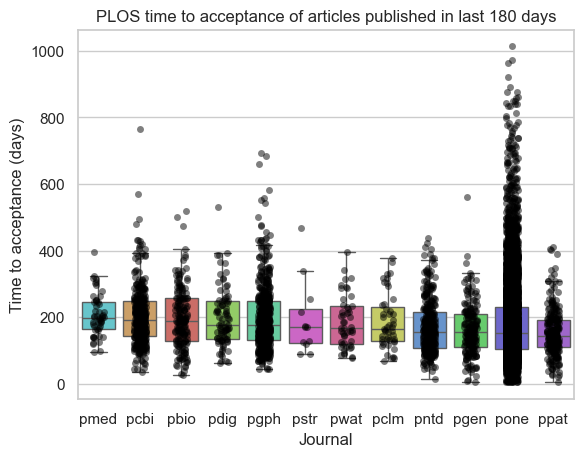

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

sns.set(style = "whitegrid")

ax = sns.boxplot(data = df_6mo, 
            x = "journal", 
            y = "accept_time",
            hue = "journal",
            order = summary_df["journal"].tolist(),
            fliersize = 0,
            palette = "hls")

ax.set(title = "PLOS time to acceptance of articles published in last 180 days",
       xlabel = "Journal",
       ylabel = "Time to acceptance (days)")

ax = sns.stripplot(data = df_6mo, 
            x = "journal", 
            y = "accept_time",
            order = summary_df["journal"].tolist(),
            color = "black",
            jitter = 0.15,
            alpha = 0.5)

plt.show()


# End of notebook